In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sys
sys.path.append("/root/sda/")
from sda.mcs import *
from sda.score import *
from sda.utils import *

from utils import *

chain = make_chain()

/tmp/ipykernel_732161/437790684.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
APPROXS = {
    1: 'cheerful-mandu-24_kv4670me',
    2: 'fortuitous-monkey-23_5knplrqr',
    3: 'alight-orchid-19_cwl0kqrg',
    4: 'alight-orchid-19_cwl0kqrg',
    8: 'filigreed-dragon-21_bxksae8w',
} 

## Settings

In [3]:
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 5))

rc = {
    'axes.axisbelow': True,
    'axes.linewidth': 1.0,
    'axes.prop_cycle': plt.cycler('color', colors),
    'figure.dpi': 150,
    'figure.figsize': (6.4, 4.8),
    'font.size': 12.0,
    'legend.fontsize': 'xx-small',
    'lines.linewidth': 1.0,
    'lines.markersize': 2.5,
    'savefig.transparent': True,
    'xtick.labelsize': 'x-small',
    'xtick.major.width': 1.0,
    'ytick.labelsize': 'x-small',
    'ytick.major.width': 1.0,
    'font.family': ['serif'],
    'text.usetex': True,
}

plt.rcParams.update(rc)

## Statistics

In [4]:
with h5py.File(PATH / 'data/test.h5', mode='r') as f:
    x_star = torch.from_numpy(f['x'][1, :257])
    y_star = torch.normal(x_star[::8, :1], 0.05)

A = lambda x: chain.preprocess(x)[..., :1]
sigma = 0.05
step = 8

In [5]:
x_bpf = posterior(y_star, A, sigma, step, particles=2**16)[:1024]

In [6]:
APPROXS = {
    1: 'polar-capybara-13_y1g6w4jm',
    2: 'snowy-leaf-29_711r6as1',
    3: 'ruby-serenity-42_nbhxlnf9',
    4: 'light-moon-51_09a36gw8',
    8: 'lilac-bush-61_7f0sioiw',
}

In [6]:
xs = []

for k, approx in APPROXS.items():
    score = load_score(PATH / f'runs/{approx}/state.pth', local=k < 8)
    sde = VPSDE(
        GaussianScore(
            y_star,
            A=lambda x: x[..., ::step, :1],
            std=sigma,
            sde=VPSDE(score, shape=()),
        ),
        shape=x_star.shape,
    ).cuda()

    x = sde.sample((64,), steps=256, corrections=2, tau=0.5).cpu()
    x = chain.postprocess(x)

    xs.append(x)

100%|█████████████████████████████████████████████████| 256/256 [00:13<00:00, 18.72it/s]


In [22]:
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)


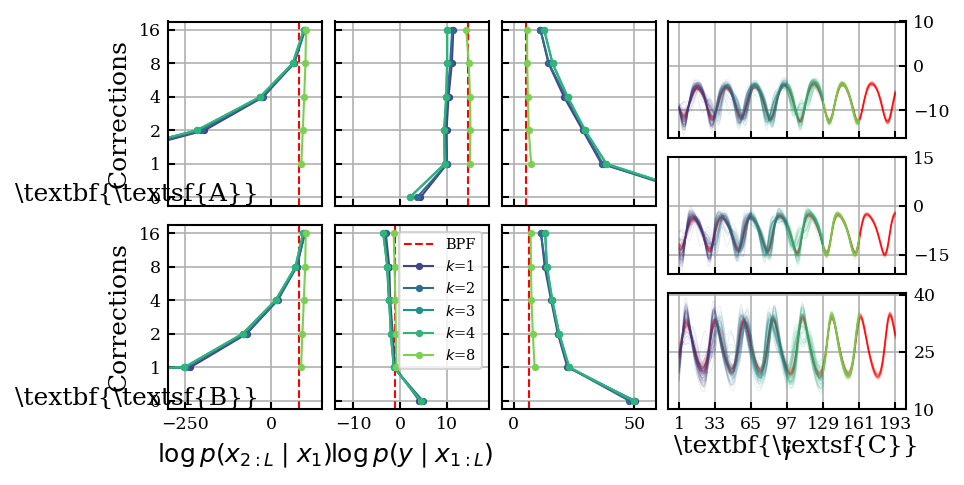

In [28]:
fig, axs = plt.subplot_mosaic([
    ['A', 'A', 'B', 'B', 'C', 'C', 0, 0, 0],
    ['A', 'A', 'B', 'B', 'C', 'C', 0, 0, 0],
    ['A', 'A', 'B', 'B', 'C', 'C', 1, 1, 1],
    ['D', 'D', 'E', 'E', 'F', 'F', 1, 1, 1],
    ['D', 'D', 'E', 'E', 'F', 'F', 2, 2, 2],
    ['D', 'D', 'E', 'E', 'F', 'F', 2, 2, 2],
], figsize=(6.4, 3.2))

axs['B'].sharey(axs['A'])
axs['C'].sharey(axs['A'])
axs['E'].sharey(axs['D'])
axs['F'].sharey(axs['D'])

axs['A'].sharex(axs['D'])
axs['B'].sharex(axs['E'])
axs['C'].sharex(axs['F'])

axs[1].sharex(axs[0])
axs[2].sharex(axs[0])
    
# Statistics
coordinates = zip(
    'ABCDEF',
    itertools.product(('lo', 'hi'), ('log_px', 'log_py', 'w1'))
)

for key, (freq, column) in coordinates:
    ax = axs[key]    
    df = pd.read_csv(PATH / f'results/stats_{freq}.csv', header=None, names=['approx', 'corrections', 'log_px', 'log_py', 'w1'])
    df = df.groupby(['approx', 'corrections'], dropna=False).median().reset_index()

    ax.axvline(df[column][df['approx'] == 'ground-truth'].to_numpy(), ls='--', color='r', label='BPF')

    for k, approx in APPROXS.items():
        df_ = df[df['approx'] == approx]

        if k > 4:
            df_ = df_[df_['corrections'] > 0]

        ax.plot(df_[column], df_['corrections'], '-o', label=f'$k$={k}')

        if column == 'log_px':
            ax.set_xlabel('$\log p(x_{2:L} \mid x_1)$')
            ax.set_xlim(-299, 149)
        elif column == 'log_py':
            ax.set_xlabel('$\log p(y \mid x_{1:L})$')
            ax.set_xlim(-14, 19)
        elif column == 'w1':
            # ax.set_xlabel('$W_1$')
            ax.set_xlim(-5, 59)

    if key == 'A':
        ax.text(-0.2, 0.025, r'\textbf{\textsf{A}}', transform=ax.transAxes, ha='center')
    elif key == 'D':
        ax.text(-0.2, 0.025, r'\textbf{\textsf{B}}', transform=ax.transAxes, ha='center')
    elif key == 'E':
        ax.legend()

    ax.set_ylabel('Corrections')
    ax.set_yscale('symlog', base=2, linthresh=1, linscale=0.5)
    ax.set_yticks([0, 1, 2, 4, 8, 16])
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

    ax.tick_params(direction='in')
    ax.label_outer()
    ax.grid()

# Example
for i in range(3):
    ax = axs[i]

    ax.plot(
        range(1, 32 * 6 + 2),
        x_bpf[:64, 0:32 * 6 + 1, i].T,
        color='red',
        lw=0.5,
        alpha=0.05,
    )

    for j, x in enumerate(xs):
        ax.plot(
            range(32 * j + 1, 32 * (j+1) + 2),
            x[:, 32 * j:32 * (j+1) + 1, i].T,
            color=f'C{j}',
            lw=0.5,
            alpha=0.1,
        )

    if i == 0:
        # ax.set_ylabel('$a$')
        ax.set_yticks([-10, 0, 10])
    elif i == 1:
        # ax.set_ylabel('$b$')
        ax.set_yticks([-15, 0, 15])
    elif i == 2:
        # ax.set_ylabel('$c$')
        ax.set_yticks([10, 25, 40])
        ax.text(0.025, -0.375, r'\textbf{\textsf{C}}', transform=ax.transAxes)

    ax.set_xlabel('$i$')
    ax.set_xticks(range(1, 7 * 32 + 1, 32))

    ax.yaxis.set_label_position('right')
    ax.yaxis.label.set(rotation='horizontal', ha='left', va='center')
    ax.yaxis.tick_right()

    ax.tick_params(direction='in')
    ax.label_outer()
    ax.grid()

fig.tight_layout(pad=0.5)
fig.align_labels()
# fig.savefig('statistics.pdf', pad_inches=0.025, bbox_inches='tight')

## Multimodal posterior

In [9]:
with h5py.File(PATH / 'data/test.h5', mode='r') as f:
    x_star = torch.from_numpy(f['x'][0, :49])
    y_star = torch.normal(x_star[::4, 2:], 0.1)

A = lambda x: chain.preprocess(x)[..., 2:]
sigma = 0.1
step = 4

In [10]:
# score = load_score(PATH / 'runs/polar-capybara-13_y1g6w4jm/state.pth', local=True)  # k = 1, width = 128
# score = load_score(PATH / 'runs/snowy-leaf-29_711r6as1/state.pth', local=True)  # k = 2, width = 128
# score = load_score(PATH / 'runs/ruby-serenity-42_nbhxlnf9/state.pth', local=True)  # k = 3, width = 256
# score = load_score(PATH / 'runs/lyric-sponge-49_pzxzijbx/state.pth', local=True)  # k = 4, width = 256

score = load_score(PATH / 'runs/lilac-bush-61_7f0sioiw/state.pth', local=False)  # k = 8, width = 64
score = MCScoreWrapper(score)

In [11]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=lambda x: x[..., ::step, 2:],
        std=sigma,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

xa = sde.sample((256,), steps=256, corrections=2, tau=0.5).cpu()
xa = chain.postprocess(xa)

ya = torch.normal(A(xa[:, ::step]), sigma).flatten(-2)

100%|██████████| 256/256 [00:04<00:00, 61.78it/s]


In [12]:
xb = []

for i in range(32):
    xb.append(weak_4d_var(xa[i], y_star, A, sigma, step))

xb = torch.stack(xb)

match = (xb - xb[:, None]).square().sum(dim=(-1, -2)) < 10
mask = torch.tril(match, -1).sum(dim=-1) == 0

xb = xb[mask]

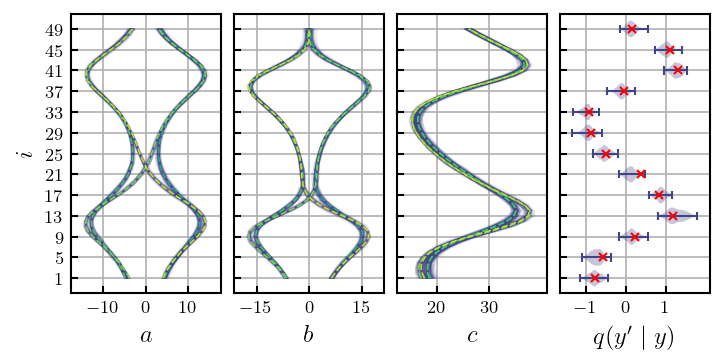

In [13]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(4.8, 2.4))

for i, ax in enumerate(axs.flat):
    if i < 3:
        ax.plot(xa[:, :, i].T, range(1, 50), color=plt.cm.viridis(0.2), lw=0.5, alpha=0.1)

        for j in range(4):
            ax.plot(xb[j, :, i], range(1, 50), color=plt.cm.viridis(0.6 + 0.1 * j), lw=0.8, ls='--')
    else:
        ax.violinplot(ya.T, range(1, 50, step), vert=False, widths=3.2)
        ax.plot(y_star, range(1, 50, step), 'x', markersize=4, color='red')

    if i == 0:
        ax.set_xlabel('$a$')
        ax.set_xticks([-10, 0, 10])
    elif i == 1:
        ax.set_xlabel('$b$')
        ax.set_xticks([-15, 0, 15])
    elif i == 2:
        ax.set_xlabel('$c$')
        ax.set_xticks([20, 30])
    elif i == 3:
        ax.set_xlabel('$q(y\' \mid y)$')
        ax.set_xticks([-1, 0, 1])

    ax.set_ylabel('$i$')
    ax.set_yticks(range(1, 50, step))
    ax.margins(0.1, 0.025)

    ax.tick_params(direction='in')
    ax.label_outer()
    ax.grid()

fig.tight_layout(pad=0.5)
fig.align_labels()
fig.savefig('multimodal.pdf', pad_inches=0.025, bbox_inches='tight')